# Experiment: Kernel Weight Optimization
In this experiment, we investigate the effectiveness of combining multiple kernels in a Gaussian Process (GP) model for predicting search volume trends across three groups: Soccer (D1), Political (D2), and Tech (D3). The focus is on optimizing kernel weights to determine which kernels contribute most significantly to the predictive performance.

## Procedure
Combine Squared-Exponential (SE) kernel, Linear kernel, Matern kernel, Sinusoidal kernel, and Spectral Mixture kernel (10 mixture components).

In [17]:
import numpy as onp
import matplotlib.pyplot as plt

from sparse_gp import *
from plots import *
from data import *

prng_key = random.key(0)

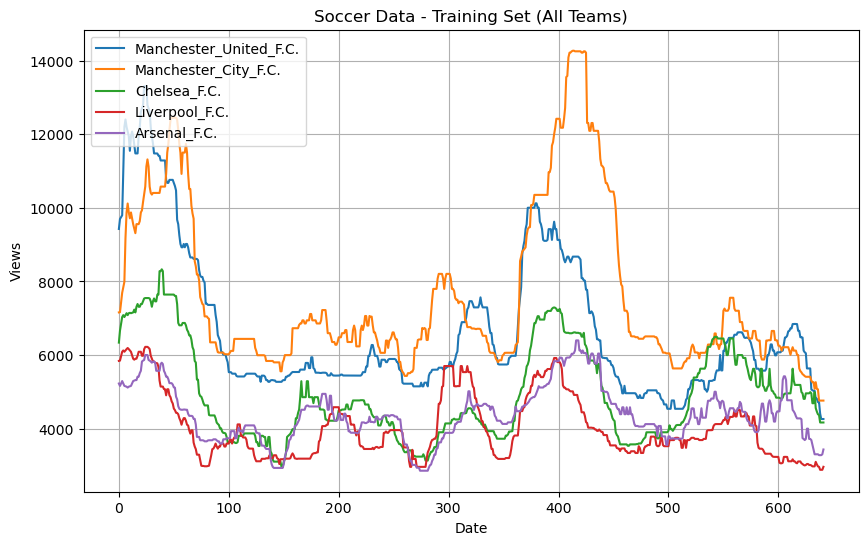

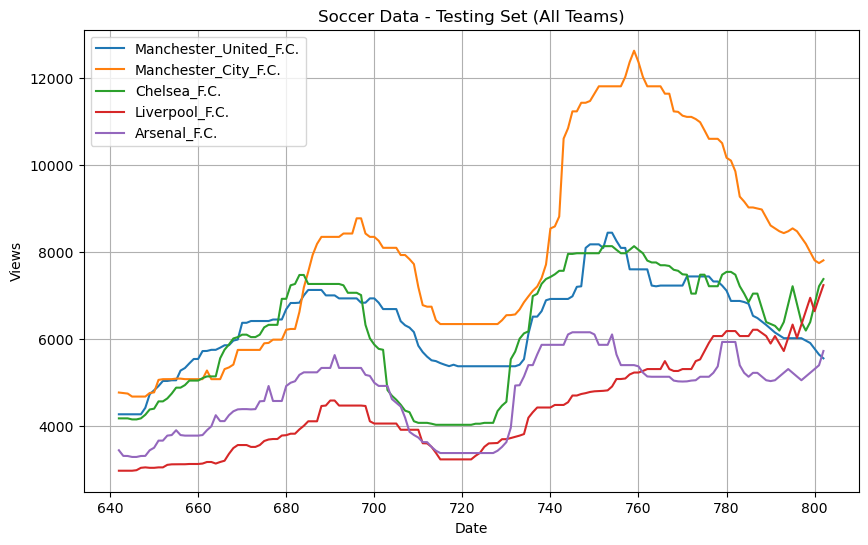

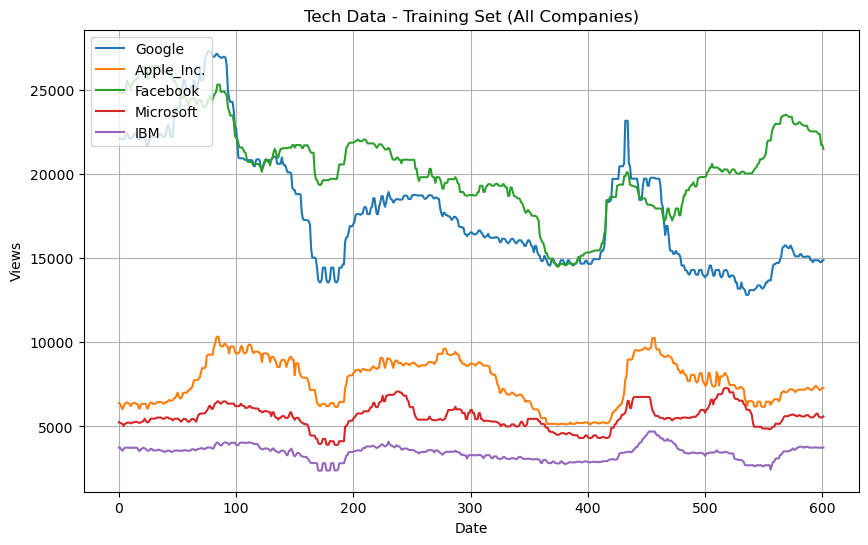

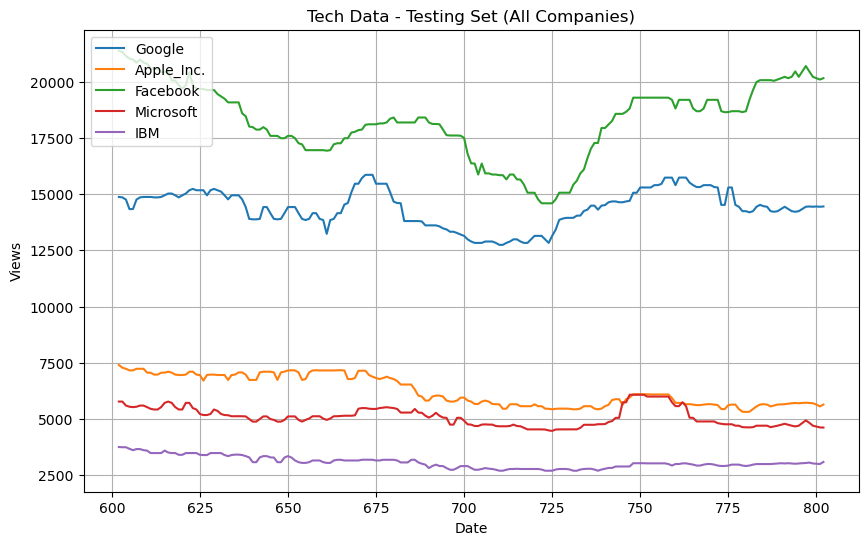

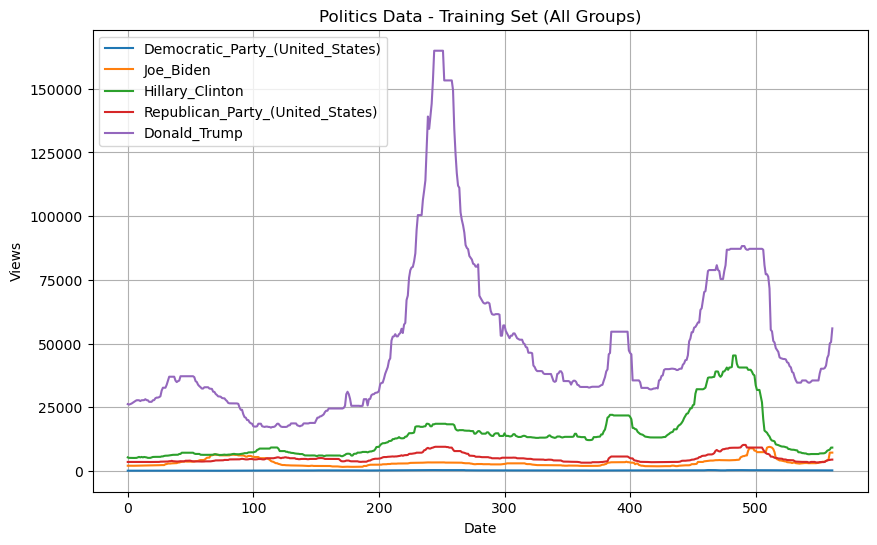

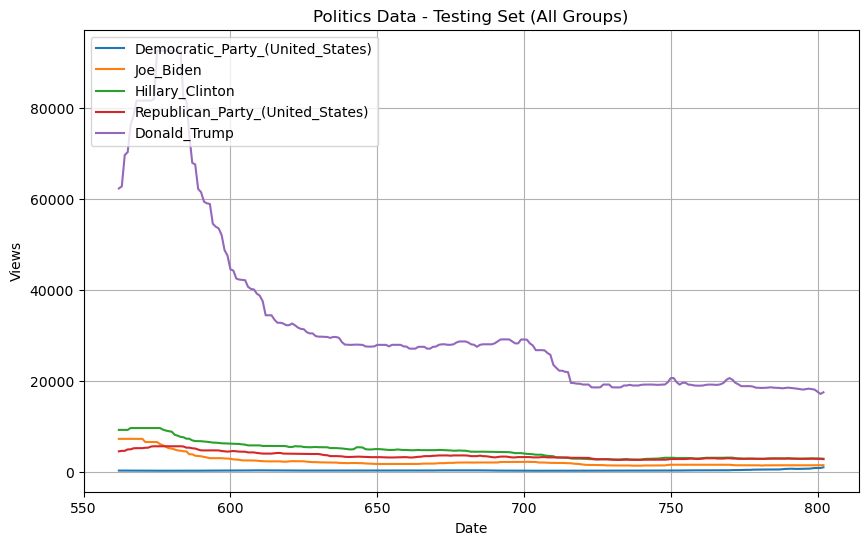

In [18]:
# Load datasets
all_data = load_all()
tech = load_tech()
politics = load_politics()
soccer = load_soccer()

# --- Soccer Data ---
# Extract names and values for soccer data
soccer_names, soccer_values = extract_names_and_values(soccer)

# Add feature names for soccer
soccer_feature_names = ["time_step"] + soccer_names

# Apply smoothing to soccer data
smoothed_soccer = smooth_data(soccer_values)

# Split Soccer data into training and testing sets
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = split_train_test_matrix(
    soccer, train_ratio=0.8, target_column=0
)

# Generate integer day labels
time_train_soccer = np.arange(X_train_soccer.shape[0])  # Days for training set
time_test_soccer = np.arange(X_train_soccer.shape[0], X_train_soccer.shape[0] + X_test_soccer.shape[0])  # Days for testing set

# Plot all soccer teams in the training set
plot_group(
    names=soccer_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_soccer[:, :X_train_soccer.shape[0]],
    dates=time_train_soccer,
    title="Soccer Data - Training Set (All Teams)"
)

# Plot all soccer teams in the testing set
plot_group(
    names=soccer_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_soccer[:, X_train_soccer.shape[0]:],
    dates=time_test_soccer,
    title="Soccer Data - Testing Set (All Teams)"
)


# --- Tech Data ---
# Extract names and values for tech data
tech_names, tech_values = extract_names_and_values(tech)

# Add feature names for tech
tech_feature_names = ["time_step"] + tech_names

# Apply smoothing to tech data
smoothed_tech = smooth_data(tech_values)

# Split Tech data into training and testing sets
X_train_tech, X_test_tech, y_train_tech, y_test_tech = split_train_test_matrix(
    tech, train_ratio=0.75, target_column=0
)

# Generate integer day labels for Tech
time_train_tech = np.arange(X_train_tech.shape[0])
time_test_tech = np.arange(X_train_tech.shape[0], X_train_tech.shape[0] + X_test_tech.shape[0])

# Plot all tech companies in the training set
plot_group(
    names=tech_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_tech[:, :X_train_tech.shape[0]],
    dates=time_train_tech,
    title="Tech Data - Training Set (All Companies)"
)

# Plot all tech companies in the testing set
plot_group(
    names=tech_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_tech[:, X_train_tech.shape[0]:],
    dates=time_test_tech,
    title="Tech Data - Testing Set (All Companies)"
)


# --- Politics Data ---
# Extract names and values for politics data
politics_names, politics_values = extract_names_and_values(politics)

# Add feature names for politics
politics_feature_names = ["time_step"] + politics_names

# Apply smoothing to politics data
smoothed_politics = smooth_data(politics_values)

# Split Politics data into training and testing sets
X_train_politics, X_test_politics, y_train_politics, y_test_politics = split_train_test_matrix(
    politics, train_ratio=0.7, target_column=0
)

# Generate integer day labels for Politics
time_train_politics = np.arange(X_train_politics.shape[0])
time_test_politics = np.arange(X_train_politics.shape[0], X_train_politics.shape[0] + X_test_politics.shape[0])

# Plot all political groups in the training set
plot_group(
    names=politics_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_politics[:, :X_train_politics.shape[0]],
    dates=time_train_politics,
    title="Politics Data - Training Set (All Groups)"
)

# Plot all political groups in the testing set
plot_group(
    names=politics_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_politics[:, X_train_politics.shape[0]:],
    dates=time_test_politics,
    title="Politics Data - Testing Set (All Groups)"
)


# Soccer Data
Test on soccer data with 100 inducing points.

## Parameter Initialization

In [19]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=100)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)

## Define the Optimization Loop for ELBO

In [20]:
# Set the gradient ascent step size and number of steps
step_size = 1e-7
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -575815048.8141729
Step 10, ELBO: -11667.960389933005
Step 20, ELBO: -11652.401136048116
Step 30, ELBO: -11636.877576987958
Step 40, ELBO: -11621.457808373225
Step 50, ELBO: -11606.064672505387
Step 60, ELBO: -11590.700111661865
Step 70, ELBO: -11575.44506578741
Step 80, ELBO: -11560.2179985231
Step 90, ELBO: -11545.017623536953
Step 100, ELBO: -11529.927225040949
Step 110, ELBO: -11514.863572350954
Step 120, ELBO: -11499.826663789247
Step 130, ELBO: -11484.889472534314
Step 140, ELBO: -11469.987914258241
Step 150, ELBO: -11455.111894065973
Step 160, ELBO: -11440.319316805497
Step 170, ELBO: -11425.577323826004
Step 180, ELBO: -11410.86092598509
Step 190, ELBO: -11396.21078981345
Optimized Hyperparameters: [1.22500145e+00 9.99994993e-01 1.36791909e+00 1.05829525e+00
 2.27028513e+00 8.68809844e+04 3.32989907e+00 2.20801172e+04
 8.68809844e+04 2.71826220e+00 8.68809844e+04 3.71841192e+00
 1.71421426e+04 8.68809844e+04 2.87672997e+00 2.20264648e+04
 2.71885395e+00 8.68809844

In [21]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 434404.94


## Predict and Plot the Results

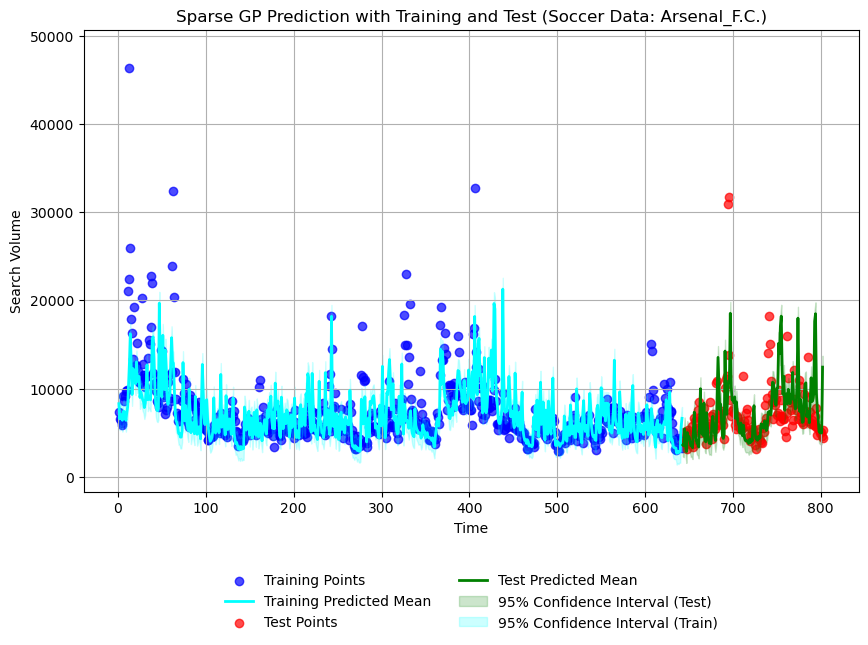

In [22]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

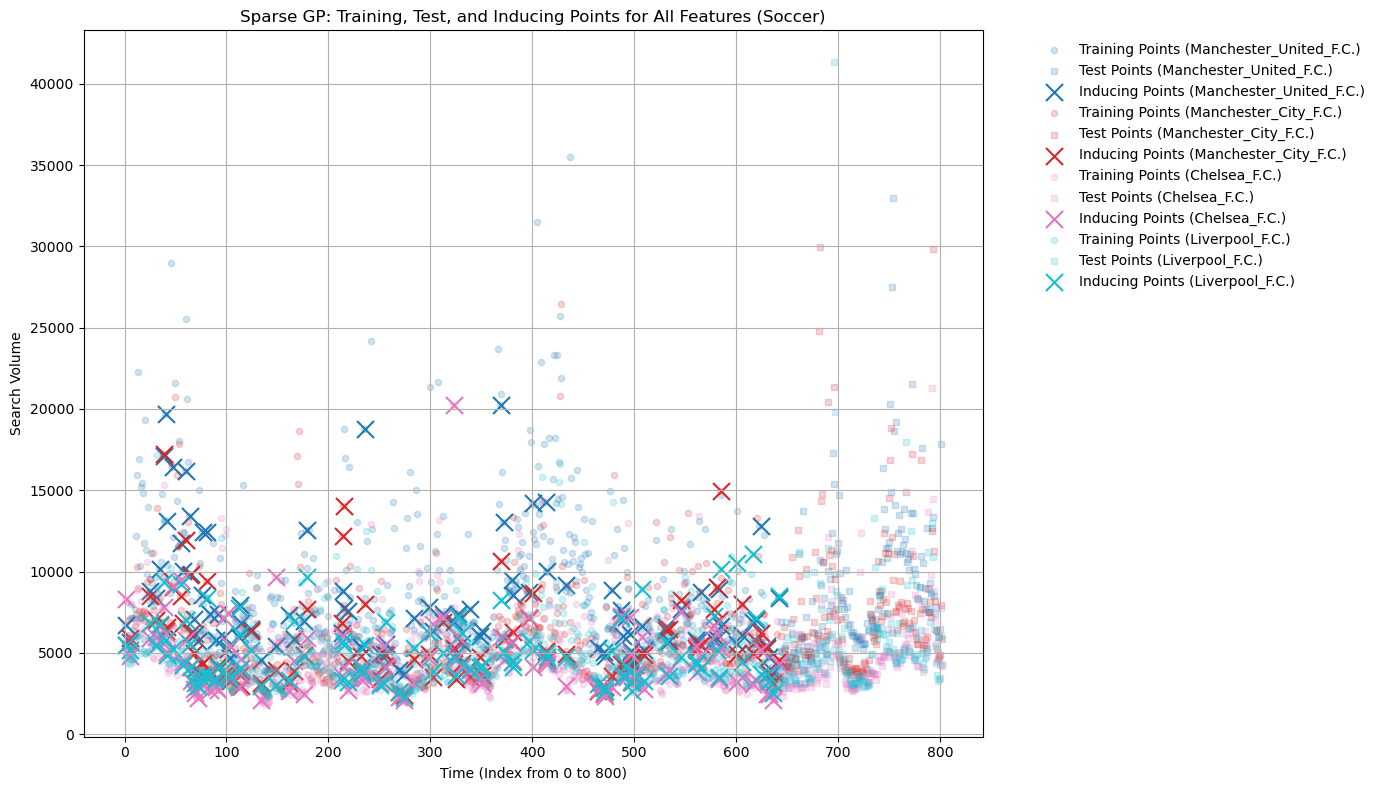

In [23]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [24]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.2250
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.3679
Kernel 4 (Sinusoidal): 1.0583
Kernel 5 (Spectral Mixture): 2.2703

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 17.70%
Kernel 2 (Linear): 14.45%
Kernel 3 (Matérn): 19.76%
Kernel 4 (Sinusoidal): 15.29%
Kernel 5 (Spectral Mixture): 32.80%

Other Hyperparameters:
Kernel 1 - Noise Variance: 86880.9844
Kernel 1 - Signal Variance: 3.3299
Kernel 1 - Length Scale: 22080.1172
Kernel 2 - Noise Variance: 86880.9844
Kernel 2 - Signal Variance: 2.7183
Kernel 3 - Noise Variance: 86880.9844
Kernel 3 - Signal Variance: 3.7184
Kernel 3 - Length Scale: 17142.1426
Kernel 4 - Noise Variance: 86880.9844
Kernel 4 - Signal Variance: 2.8767
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7189
Kernel 5 - Noise Variance: 86880.9844

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1996
Means: [0.22082484 0.8361463  0.0082743  1.3717978  3.6921637 ]
Variances: [1.78990135e+01 3.2699

## NLPD

In [25]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 14.5278
Test NLPD: 17.7697


## MSE

In [26]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 17400173.6771


## ELBO Maximization

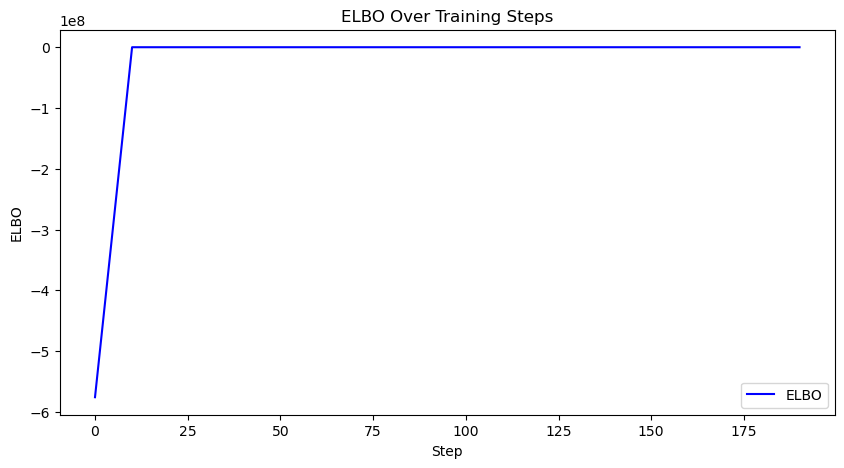

In [27]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Weight (Squared-Exponential)
 - Weight (Spectral Mixture)
 - Signal Variance (Sq-Exp)
 - Length Scale (Sq-Exp)
 - Length Scale (Matern)
 - Signal Variance (Sinusoidal)
 - Length Scale (Sinusoidal)
 - Period (Sinusoidal)
 - SM Weight 1
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Weight 2
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Weight 3
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Weight 4
 - SM Mean 4, Dim 1
 - SM Vari

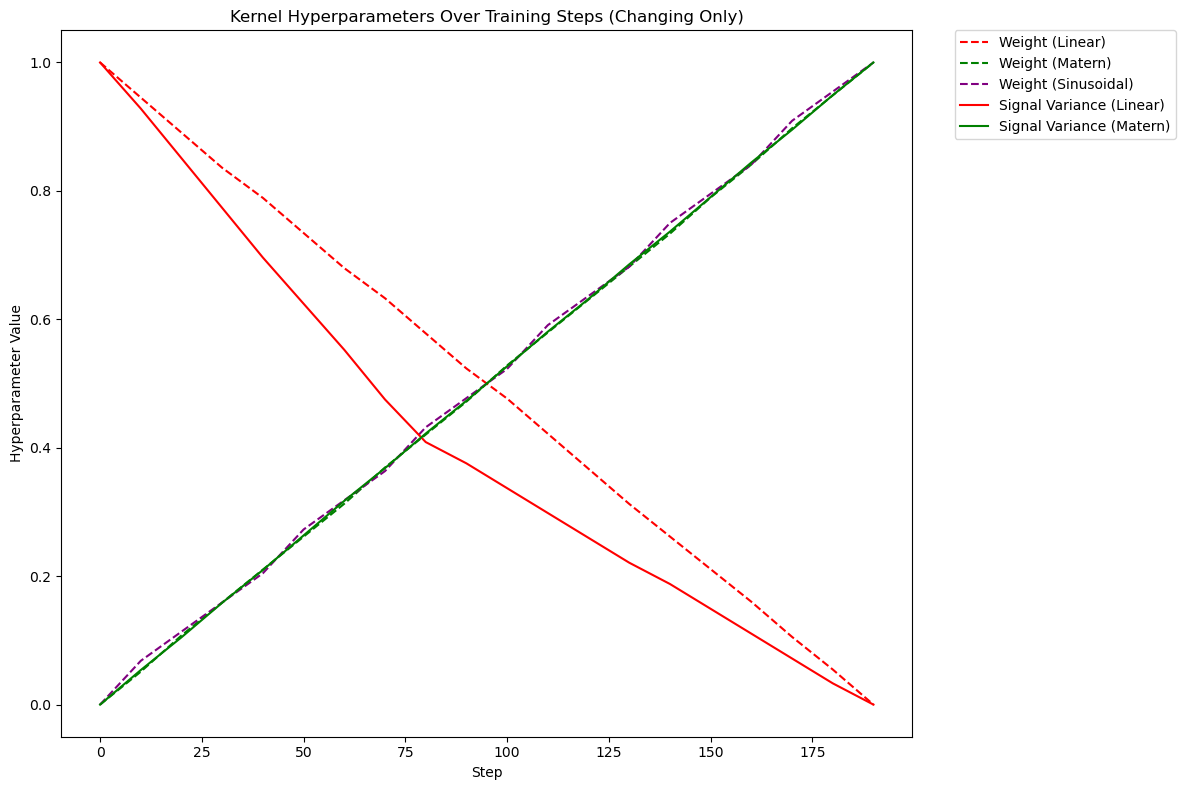

In [28]:
plot_kernel_hyperparameters(history, dims=5)

## Political Data

In [29]:
grab_prng()
#init inducing points + unconstrained HPs
Z= initialize_inducing_points(X_train_politics,100)
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_politics)


In [30]:
# Set the gradient ascent step size and number of steps
step_size = 1e-7
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_politics, y_train_politics, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -81673177.54189534
Step 10, ELBO: -3974439.3047386985
Step 20, ELBO: -2225635.6764771747
Step 30, ELBO: -1554076.809340609
Step 40, ELBO: -1196415.3843907495
Step 50, ELBO: -973635.3728292243
Step 60, ELBO: -821308.4455931791
Step 70, ELBO: -710472.5946021589
Step 80, ELBO: -626153.763638984
Step 90, ELBO: -559824.5891469662
Step 100, ELBO: -506264.82023060333
Step 110, ELBO: -462100.91477158736
Step 120, ELBO: -425053.6618396647
Step 130, ELBO: -393526.39694475604
Step 140, ELBO: -366368.31272050546
Step 150, ELBO: -342728.1665915452
Step 160, ELBO: -321962.7522442554
Step 170, ELBO: -303576.71645136614
Step 180, ELBO: -287182.4771445868
Step 190, ELBO: -272472.7670566127
Optimized Hyperparameters: [9.35956955e-01 9.99733031e-01 1.55334020e+00 1.50048196e+00
 7.75674164e-01 3.79671814e+02 2.54419541e+00 2.20264863e+04
 3.79671814e+02 2.71758175e+00 3.79671814e+02 4.22241449e+00
 2.23631133e+04 3.79671814e+02 4.07873154e+00 2.20264648e+04
 2.71872330e+00 3.79671814e+02 1.

In [31]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 1898.3591


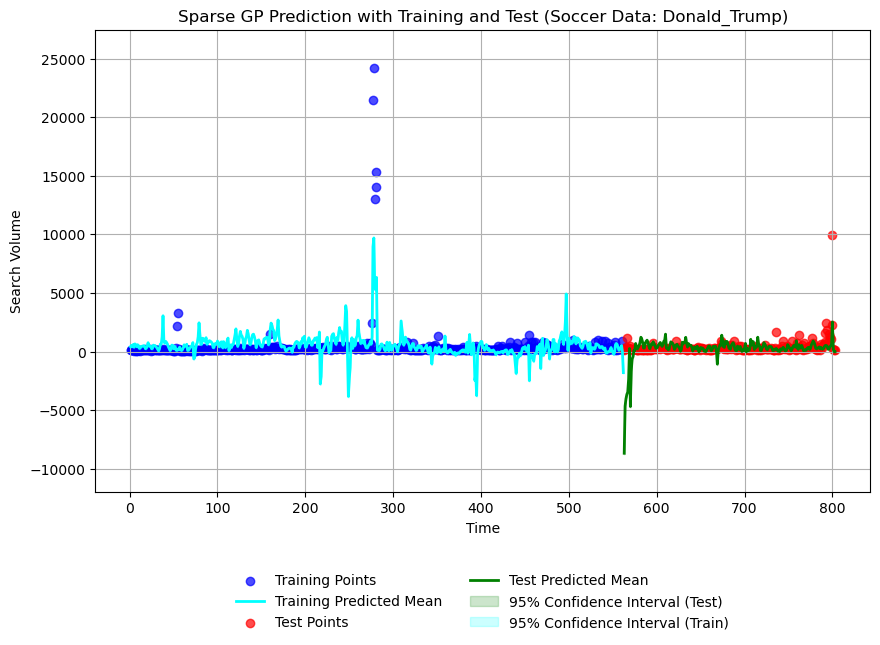

In [32]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_politics, 
    y_train_politics, 
    X_test_politics, 
    y_test_politics, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {politics_feature_names[-1]})"
)

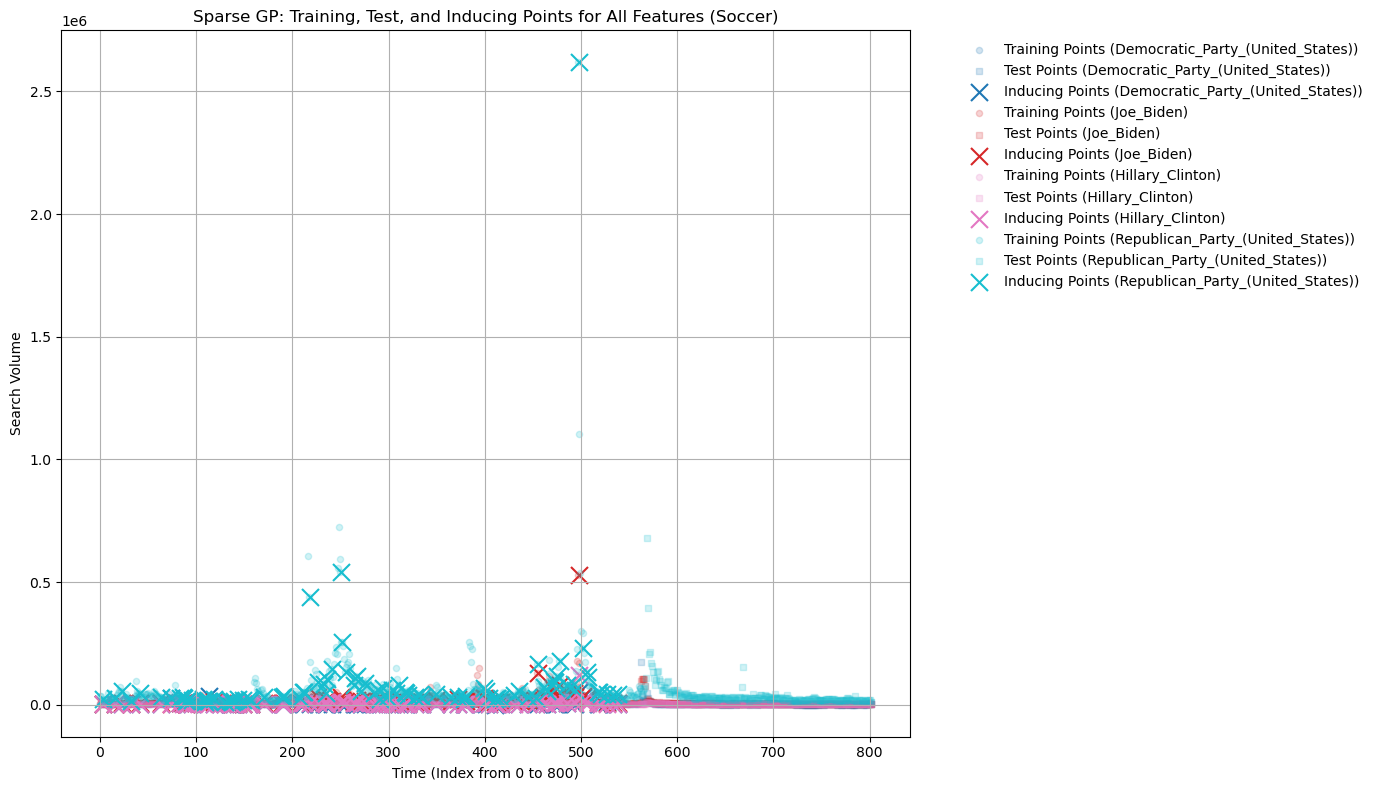

In [33]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_politics, y_train_politics, X_test_politics, y_test_politics, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Politics)", feature_names=politics_feature_names
)

In [34]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_politics.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 0.9360
Kernel 2 (Linear): 0.9997
Kernel 3 (Matérn): 1.5533
Kernel 4 (Sinusoidal): 1.5005
Kernel 5 (Spectral Mixture): 0.7757

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 16.23%
Kernel 2 (Linear): 17.34%
Kernel 3 (Matérn): 26.94%
Kernel 4 (Sinusoidal): 26.03%
Kernel 5 (Spectral Mixture): 13.45%

Other Hyperparameters:
Kernel 1 - Noise Variance: 379.6718
Kernel 1 - Signal Variance: 2.5442
Kernel 1 - Length Scale: 22026.4863
Kernel 2 - Noise Variance: 379.6718
Kernel 2 - Signal Variance: 2.7176
Kernel 3 - Noise Variance: 379.6718
Kernel 3 - Signal Variance: 4.2224
Kernel 3 - Length Scale: 22363.1133
Kernel 4 - Noise Variance: 379.6718
Kernel 4 - Signal Variance: 4.0787
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7187
Kernel 5 - Noise Variance: 379.6718

Spectral Mixture Kernel - Mixture 1:
Weight: 1.0775
Means: [ 0.03792665  0.06898853  0.55418867 15.03691     0.10657929]
Variances: [0.06002247 1.9542322  3.63

In [35]:
train_nlpd = calculate_nlpd(X_train_politics, y_train_politics, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_politics, y_train_politics)
test_nlpd = calculate_nlpd(X_test_politics, y_test_politics, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_politics, y_train_politics)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 225.9688
Test NLPD: 160.9968


In [36]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_politics, X_train_politics, y_train_politics, Z, optimized_hyperparams)
mse = calculate_mse(y_test_politics, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 1211082.0495


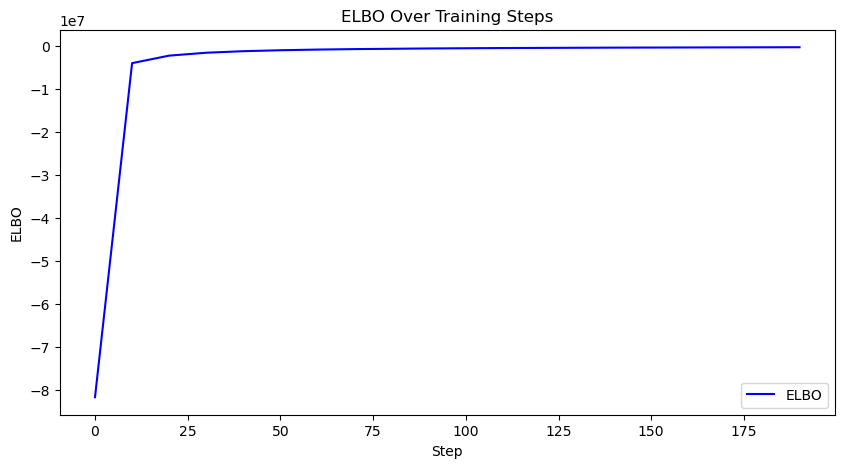

In [37]:
plot_elbo(history)

Unchanged Hyperparameters:
 - Length Scale (Sq-Exp)
 - Length Scale (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Mean 5, Dim 1
 - SM Variance 5, D

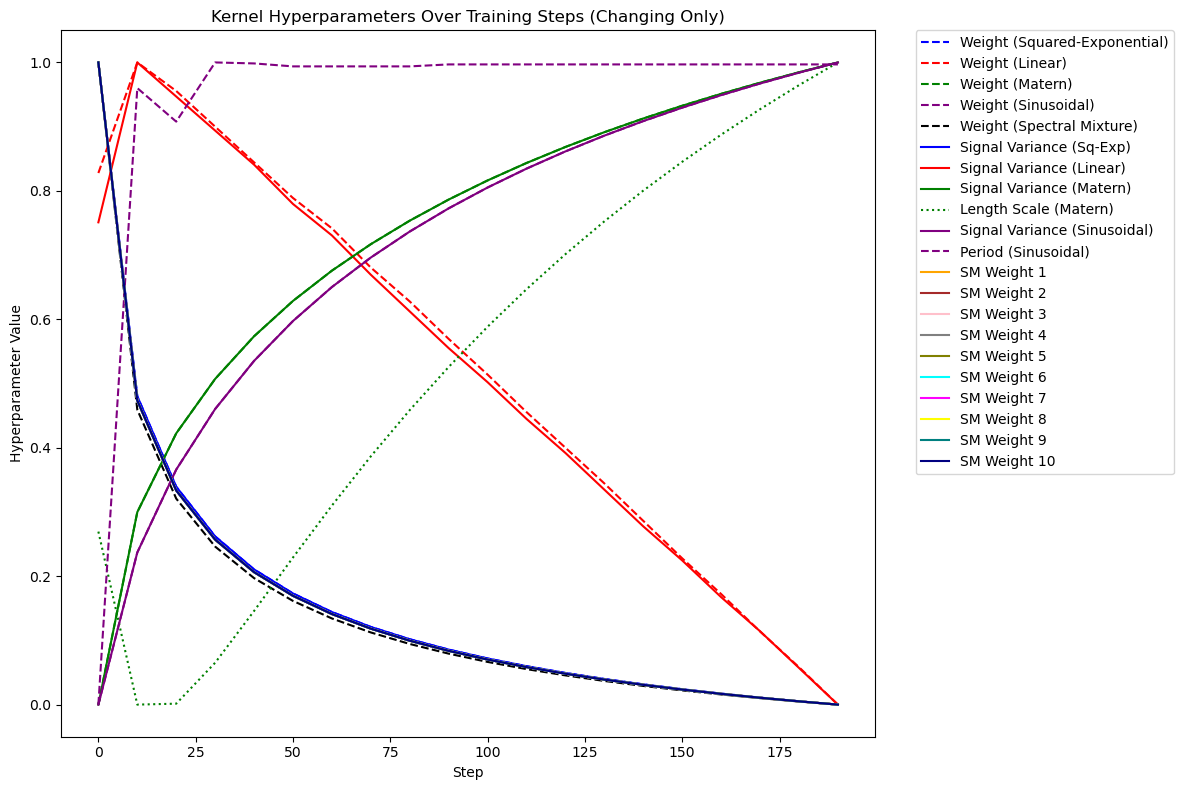

In [38]:
plot_kernel_hyperparameters(history, dims=5)

## Tech data

In [39]:
grab_prng()
#init inducing points + unconstrained HPs
Z= initialize_inducing_points(X_train_tech,100)
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_tech)


In [40]:
# Set the gradient ascent step size and number of steps
step_size = 1e-7
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_tech, y_train_tech, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -2959551803.771767
Step 10, ELBO: -9230.280897025525
Step 20, ELBO: -9230.275158533144
Step 30, ELBO: -9230.269419821938
Step 40, ELBO: -9230.2636650382
Step 50, ELBO: -9230.25792588871
Step 60, ELBO: -9230.252186520356
Step 70, ELBO: -9230.246446933124
Step 80, ELBO: -9230.240691270867
Step 90, ELBO: -9230.234967101947
Step 100, ELBO: -9230.229226857957
Step 110, ELBO: -9230.223486395036
Step 120, ELBO: -9230.217745713147
Step 130, ELBO: -9230.211988953128
Step 140, ELBO: -9230.206263692404
Step 150, ELBO: -9230.200522353522
Step 160, ELBO: -9230.19478079561
Step 170, ELBO: -9230.189039018638
Step 180, ELBO: -9230.183281160449
Step 190, ELBO: -9230.177554807502
Optimized Hyperparameters: [3.75237405e-01 9.99879479e-01 1.05328110e+07 1.87581573e+02
 1.50392111e-02 2.18761293e+24 1.02000082e+00 2.39772734e+04
 2.18761293e+24 2.71812153e+00 2.18761293e+24 2.86311480e+07
 1.89562870e-05 2.18761293e+24 5.09899597e+02 2.20264648e+04
 2.73265576e+00 2.18761293e+24 7.26360083e-0

In [41]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 1.0938065e+25


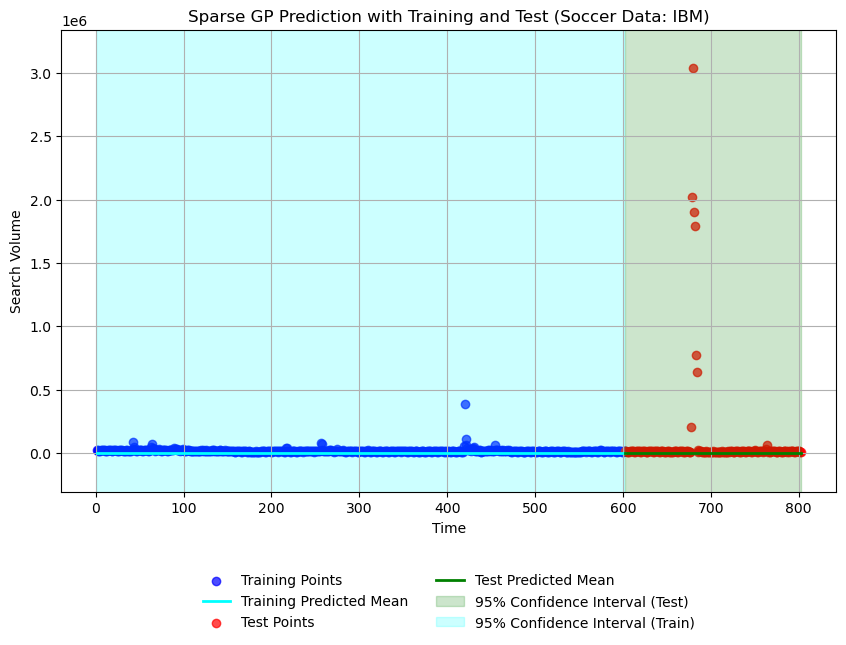

In [ ]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_tech, 
    y_train_tech, 
    X_test_tech, 
    y_test_tech, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (tech Data: {tech_feature_names[-1]})"
)

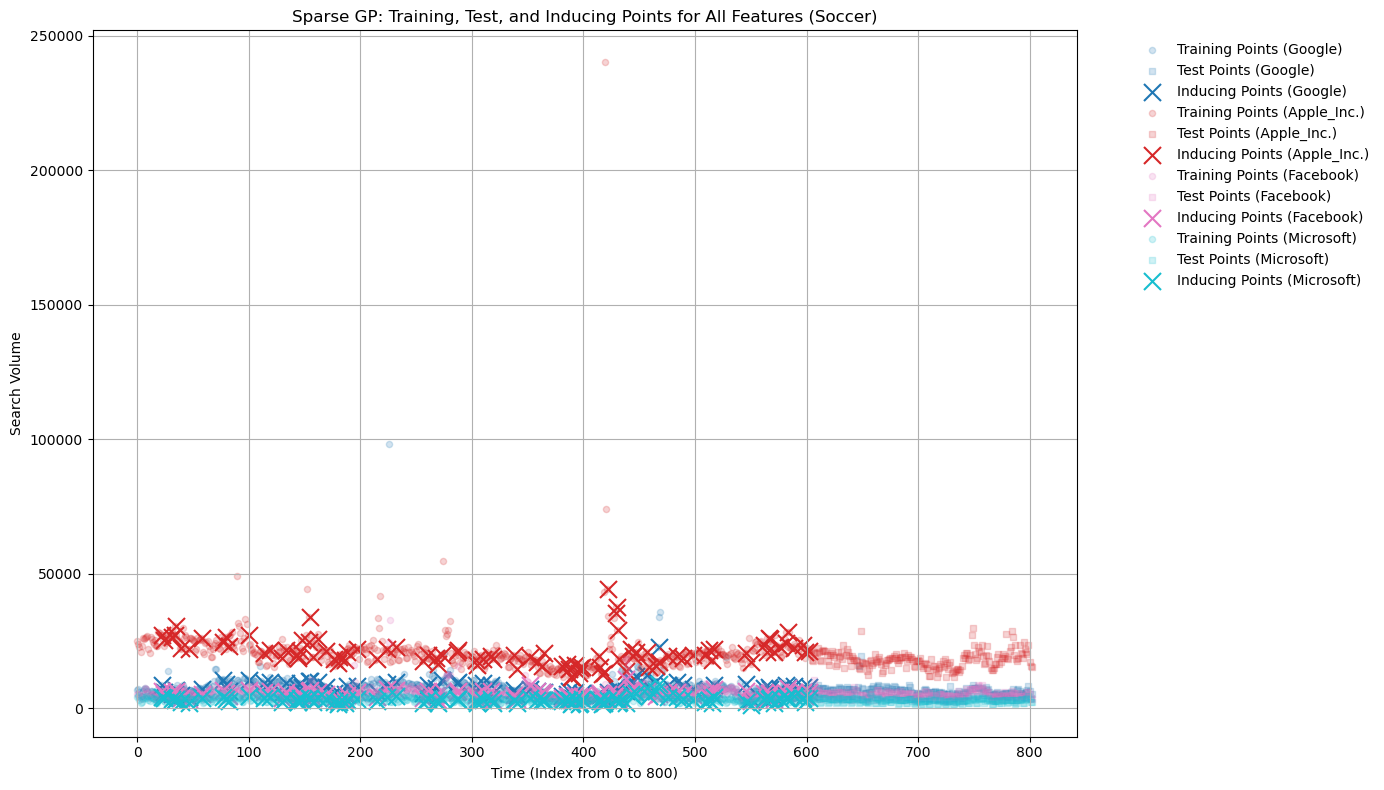

In [43]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_tech, y_train_tech, X_test_tech, y_test_tech, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Tech)", feature_names=tech_feature_names
)

In [44]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_tech.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 0.3752
Kernel 2 (Linear): 0.9999
Kernel 3 (Matérn): 10532811.0000
Kernel 4 (Sinusoidal): 187.5816
Kernel 5 (Spectral Mixture): 0.0150

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 0.00%
Kernel 2 (Linear): 0.00%
Kernel 3 (Matérn): 100.00%
Kernel 4 (Sinusoidal): 0.00%
Kernel 5 (Spectral Mixture): 0.00%

Other Hyperparameters:
Kernel 1 - Noise Variance: 2187612926528894856593408.0000
Kernel 1 - Signal Variance: 1.0200
Kernel 1 - Length Scale: 23977.2734
Kernel 2 - Noise Variance: 2187612926528894856593408.0000
Kernel 2 - Signal Variance: 2.7181
Kernel 3 - Noise Variance: 2187612926528894856593408.0000
Kernel 3 - Signal Variance: 28631148.0000
Kernel 3 - Length Scale: 0.0000
Kernel 4 - Noise Variance: 2187612926528894856593408.0000
Kernel 4 - Signal Variance: 509.8996
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7327
Kernel 5 - Noise Variance: 2187612926528894856593408.0000

Spectral Mixture Kernel - Mixture 1:
W

In [45]:
train_nlpd = calculate_nlpd(X_train_tech, y_train_tech, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_tech, y_train_tech)
test_nlpd = calculate_nlpd(X_test_tech, y_test_tech, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_tech, y_train_tech)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 30.0927
Test NLPD: 30.0927


In [46]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_tech, X_train_tech, y_train_tech, Z, optimized_hyperparams)
mse = calculate_mse(y_test_tech, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 105573111283.7512


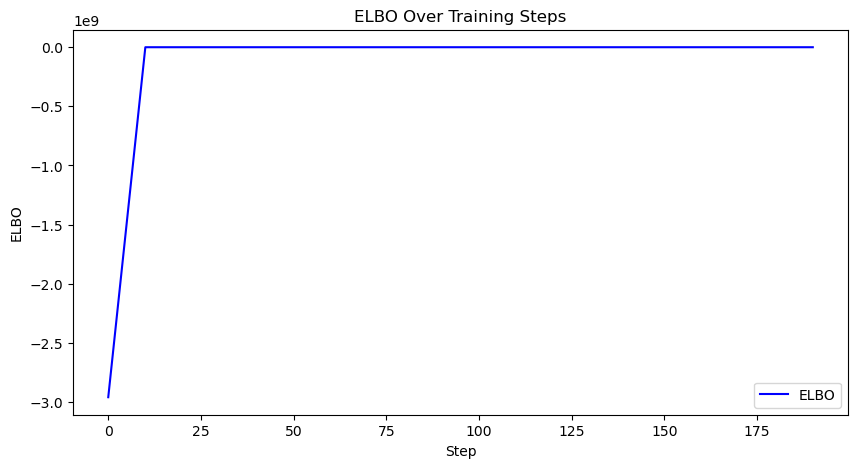

In [47]:
plot_elbo(history)

Unchanged Hyperparameters:
 - Weight (Squared-Exponential)
 - Weight (Linear)
 - Weight (Matern)
 - Weight (Sinusoidal)
 - Weight (Spectral Mixture)
 - Signal Variance (Sq-Exp)
 - Length Scale (Sq-Exp)
 - Signal Variance (Linear)
 - Signal Variance (Matern)
 - Length Scale (Matern)
 - Signal Variance (Sinusoidal)
 - Length Scale (Sinusoidal)
 - Period (Sinusoidal)
 - SM Weight 1
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Weight 2
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Weight 3
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Di

/Users/chahal/sparse-GP-kernel-combinations-audio-forecasting/plots.py:353: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)


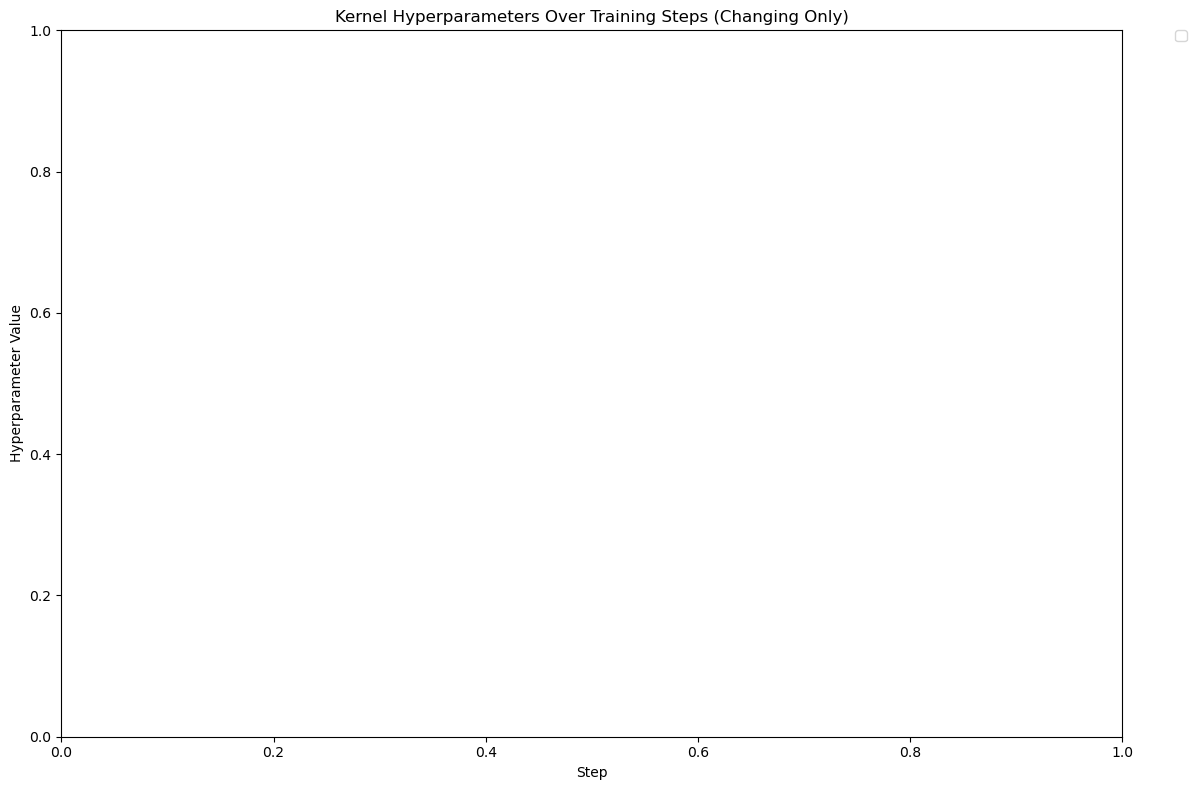

In [48]:
plot_kernel_hyperparameters(history, dims=5)